# Описание
В данной задаче нам представлены данные в которых ключевое поле — это то, просрочит ли клиент микро-финансовой организации выплату более чем на 60 дней или нет. 
Нам нужно построить модель, которая по входным данным предсказывала бы с максимальной точностью ключе-вой параметр. 
Основной параметр это delinq60plus. Остальные парамет-ры интуитивно понятны из таблиц.

## Цель
Построить модель машинного обучения для предсказания вероятности того, что клиент уйдет в просрочку более 60 дней.

## Задача
- осуществить корректную загрузку данных
- осуществить разведывательный анализ данных:
    - разбить выборку на обучающую и тестовую
    - проанализировать пропуски и решить, что с ними делать
    - проанализировать выбросы
    - создать/ удалить переменные
    - закодировать категориальные переменные
    - нормализовать числовые переменные (при необходимости)

- построить модель и оценить ее качество
- при необходимости вернуться к предыдущим шагам, чтобы улучшить качество модели 


# Выполнение

In [936]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler as MMScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV


## Чтение данных

In [937]:
df = pd.read_csv('data/MFOcredit.csv',
    encoding='cp1251',
    sep=';',
    index_col='id',
    parse_dates=['date_start', 'date_end'])
df.head(5)

,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
id,,,,,,,,,,,,,
1,2013-01-03,2013-01-12,Мужской,44,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Новосибирская область,Нет,Да,Нет
2,2013-01-03,2013-01-17,Мужской,21,Пропуск поля,Живут с родителями,Холост,Нет,Официальное,Кемеровская область юг,Да,Нет,Нет
3,2013-01-03,2013-01-17,Мужской,25,Пропуск поля,Собственное,Холост,Да,Официальное,Кемеровская область север,Пропуск поля,Нет,Нет
4,2013-01-03,2013-01-17,Женский,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область север,Нет,Нет,Нет
5,2013-01-03,2013-01-17,Мужской,22,Нет,Арендуемое,Гражданский брак/женат/замужем,Нет,Официальное,Кемеровская область север,Да,Да,Нет


In [938]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35212 entries, 1 to 35212
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_start    35212 non-null  datetime64[ns]
 1   date_end      35212 non-null  datetime64[ns]
 2   gender        35212 non-null  object        
 3   age           35212 non-null  int64         
 4   auto          35212 non-null  object        
 5   housing       35212 non-null  object        
 6   marstatus     35212 non-null  object        
 7   regclient     35212 non-null  object        
 8   jobtype       35212 non-null  object        
 9   region        35212 non-null  object        
 10  credits       35212 non-null  object        
 11  children      35212 non-null  object        
 12  delinq60plus  35212 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(10)
memory usage: 3.8+ MB


## Анализ данных

### Получение тренировочной и тестовой выборок

In [939]:
y = 'delinq60plus'

X = df.columns.to_list()
X.remove(y)

X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], train_size=0.7, random_state=123)
print(f"Train set shape: {X_train.shape}\nTest set size: {X_test.shape}\n")

Train set shape: (24648, 12)
Test set size: (10564, 12)



### Обработка пропусков

Пропусков многовато, поэтому просто удалить записи с ними скорее всего не лучший вариант. Буду заменять самым частым значением

In [940]:
columns = ['gender', 'auto', 'housing', 'marstatus', 'regclient', 'jobtype', 'region', 'credits', 'children']

def count_empties(dataframe):
    for column in columns:
        count = dataframe[dataframe[column] == "Пропуск поля" ][column].count()
        print(f"Empty values in {column.upper()}: {count}")

def replace_empties(dataframe):
    print("Empties before replacing")
    count_empties(dataframe)

    for column in columns:
        new_value = dataframe[column].value_counts().index[0]
        dataframe.loc[dataframe[column] == "Пропуск поля", column] = new_value
    
    return dataframe

In [941]:
print("X_train")
X_train = replace_empties(X_train)

print("\nEmpties after replacing")
count_empties(X_train)

X_train
Empties before replacing
Empty values in GENDER: 0
Empty values in AUTO: 9870
Empty values in HOUSING: 5370
Empty values in MARSTATUS: 5336
Empty values in REGCLIENT: 0
Empty values in JOBTYPE: 10134
Empty values in REGION: 0
Empty values in CREDITS: 676
Empty values in CHILDREN: 528

Empties after replacing
Empty values in GENDER: 0
Empty values in AUTO: 0
Empty values in HOUSING: 0
Empty values in MARSTATUS: 0
Empty values in REGCLIENT: 0
Empty values in JOBTYPE: 0
Empty values in REGION: 0
Empty values in CREDITS: 0
Empty values in CHILDREN: 0


In [942]:
print("X_test")
X_test = replace_empties(X_test);

X_test
Empties before replacing
Empty values in GENDER: 0
Empty values in AUTO: 4207
Empty values in HOUSING: 2233
Empty values in MARSTATUS: 2228
Empty values in REGCLIENT: 0
Empty values in JOBTYPE: 4323
Empty values in REGION: 0
Empty values in CREDITS: 270
Empty values in CHILDREN: 217


In [943]:
print(f"Train set shape: {X_train.shape}\nTest set size: {X_test.shape}\n")

Train set shape: (24648, 12)
Test set size: (10564, 12)



### Анализ выбросов

Вроде всё нормально. Ничего не делаем здесь

<AxesSubplot:>

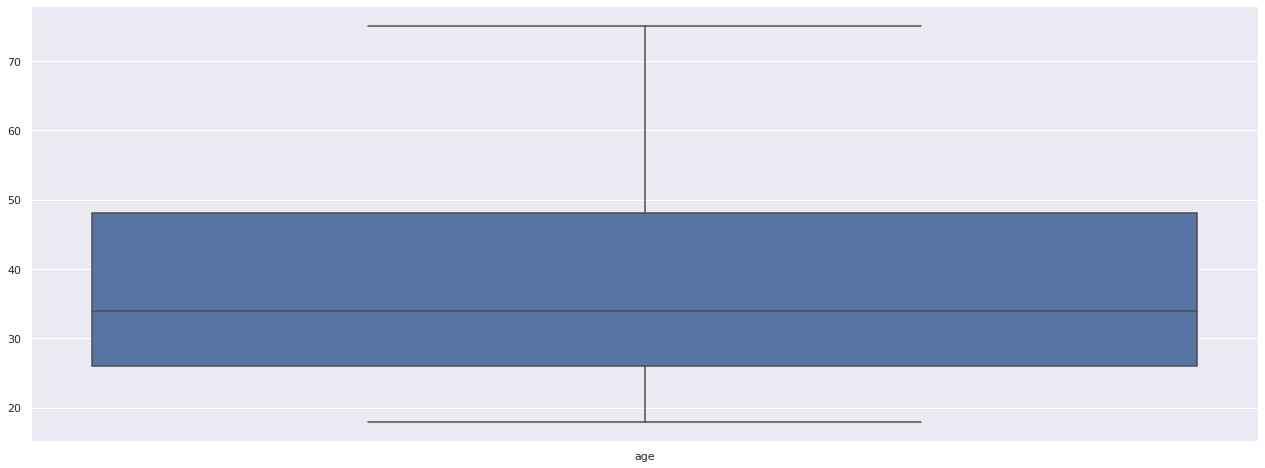

In [944]:
sns.set(rc={'figure.figsize':(22,8)})
sns.boxplot(data=X_train, width=0.9)

<AxesSubplot:>

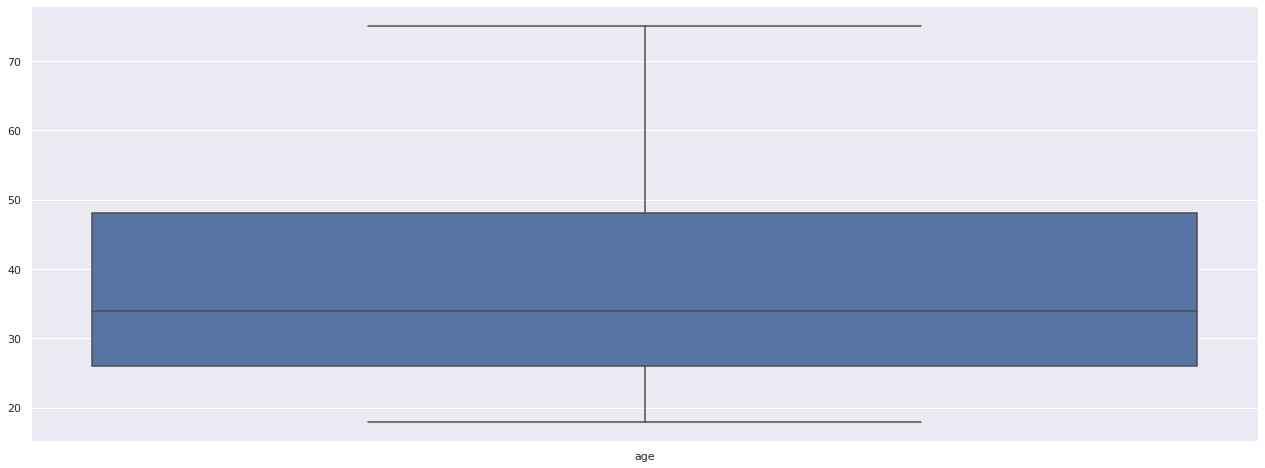

In [945]:
sns.boxplot(data=X_test, width=0.9)

### Удаляем/Создаем столбцы

Выдвину предположение, что если заменить две колонки периода займа на одну, значениями которой будут кол-во дней займа, то можно будет получить лучший результат, так как параметр станет более явно выраженным

In [946]:
def create_days_column(dataframe):
    dataframe['days_count'] = (dataframe.date_end - dataframe.date_start).dt.days
    return dataframe.drop(['date_start', 'date_end'], axis=1)

In [947]:
X_train = create_days_column(X_train)
X_train.head(5)

,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,days_count
id,,,,,,,,,,,
13470,Женский,38,Нет,Собственное,Разведен,Да,Официальное,Кемеровская область север,Да,Да,4
9616,Мужской,35,Да,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Кемеровская область север,Нет,Да,14
26587,Женский,48,Нет,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область юг,Да,Нет,14
13479,Мужской,58,Да,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Алтайский край,Да,Нет,14
9371,Мужской,31,Нет,Собственное,Холост,Да,Официальное,Новосибирская область,Да,Нет,59


In [948]:
X_test = create_days_column(X_test)
X_test.head(5)

,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,days_count
id,,,,,,,,,,,
18780,Женский,28,Нет,Собственное,Холост,Да,Официальное,Кемеровская область север,Да,Нет,14
22941,Женский,26,Нет,Арендуемое,Разведен,Нет,Официальное,Новосибирская область,Да,Да,14
35104,Мужской,59,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Красноярский край,Нет,Нет,14
3481,Мужской,27,Нет,Долевая собственность,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область юг,Нет,Нет,14
9008,Мужской,41,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Алтайский край,Да,Нет,14


### Кодировка категориальных признаков

In [949]:
def coding_features(dataframe):
    dataframe = pd.concat([dataframe,
           pd.get_dummies(dataframe['gender'], prefix='gender'),
           pd.get_dummies(dataframe['auto'], prefix='auto'),
           pd.get_dummies(dataframe['housing'], prefix='housing'),
           pd.get_dummies(dataframe['marstatus'], prefix='marstatus'),
           pd.get_dummies(dataframe['regclient'], prefix='regclient'),
           pd.get_dummies(dataframe['jobtype'], prefix='jobtype'),
           pd.get_dummies(dataframe['region'], prefix='region'),
           pd.get_dummies(dataframe['credits'], prefix='credits'),
           pd.get_dummies(dataframe['children'], prefix='children')],
           axis=1)
    
    return dataframe.drop(['gender', 'auto', 'housing', 'marstatus', 'regclient', 'jobtype', 'region', 'credits', 'children'], axis=1)

In [950]:
X_train = coding_features(X_train)
X_test = coding_features(X_test)

### Нормальность данных

In [951]:
def print_normal_info(dataframe):
    def print_is_normal(dataset, column):
        stat, p = stats.normaltest(dataset[column])
        
        alpha = 0.05
        if p > alpha:
            print(f"{column}: Принять гипотезу о нормальности")
        else:
            print(f"{column}: Отклонить гипотезу о нормальности")

    discrete_columns = ['age']
    for column in discrete_columns:
        print_is_normal(dataframe, column)
        
        sns.histplot(dataframe[column], kde=True, bins = 40, alpha = 1)
        plt.show()

age: Отклонить гипотезу о нормальности


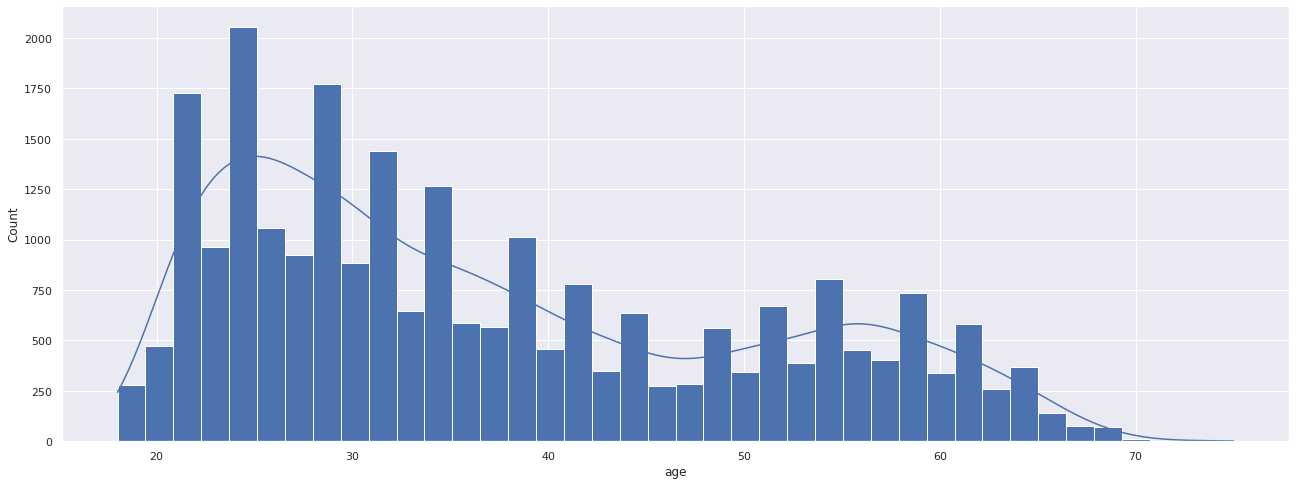

age: Отклонить гипотезу о нормальности


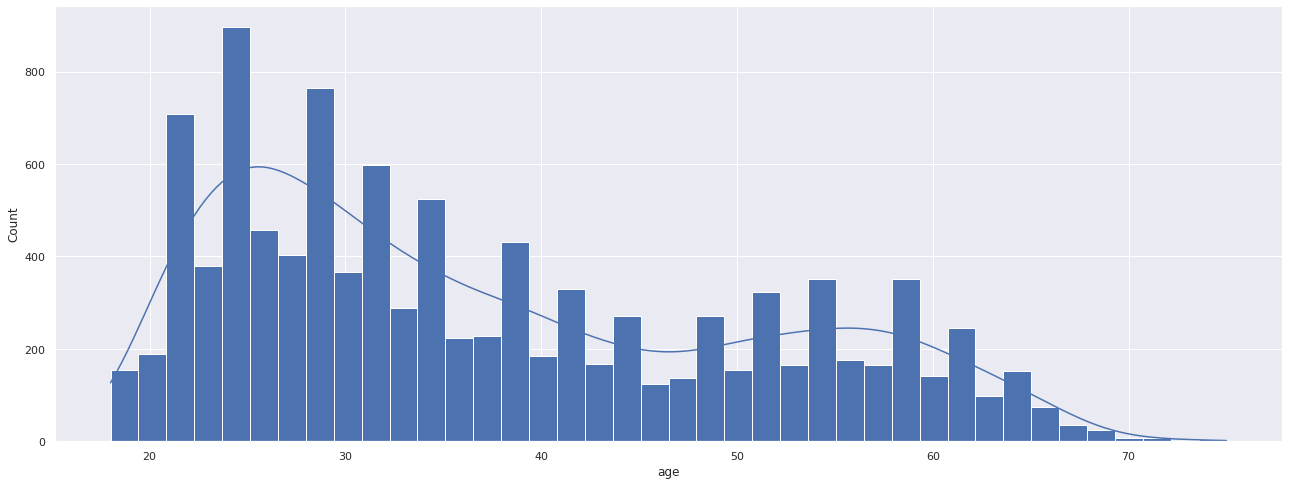

In [952]:
print_normal_info(X_train)
print_normal_info(X_test)

## Построение модели

In [953]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=50, min_samples_leaf=6, min_samples_split=4, random_state=123)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.667171525937145

In [954]:
y_pred = rfc.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.6910145297233101

In [955]:
#rfc = RandomForestClassifier()
#parametrs = { 'n_estimators': range (50, 500, 50),
#              'max_depth': range (5, 50, 5),
#              'min_samples_leaf': range (2,7,2),
#             'min_samples_split': range (2,7,2) }

#grid = GridSearchCV(rfc, parametrs, n_jobs=16).fit(X_train, y_train)

#grid.best_params_

#{'max_depth': 10,
# 'min_samples_leaf': 6,
# 'min_samples_split': 4,
# 'n_estimators': 50}